<a href="https://colab.research.google.com/github/jathusharini/intrusion-detection-fewshot-vs-traditional/blob/main/Hidden_Naive_Bayes/Hidden_Naive_Bayes_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Global constant
EPSILON = 1e-6

def load_data(filepath):
    data = pd.read_csv(filepath)
    return data

In [3]:
def preprocess_data(data):
    # Drop rows where 'Label' is missing
    if 'Label' in data.columns:
        data.dropna(subset=['Label'], inplace=True)
    else:
        raise KeyError("The 'Label' column is missing from the dataset.")

    # Drop irrelevant columns like 'Attack Type'
    data.drop(columns=['Attack Type'], errors='ignore', inplace=True)

    # Keep only numeric columns
    data = data.select_dtypes(include=[np.number])

    # Label encoding for binary classification
    label_encoder = LabelEncoder()
    data['Label'] = label_encoder.fit_transform(data['Label'])

    # Scaling
    scaler = StandardScaler()
    features = data.drop(columns=['Label'])
    scaled_features = scaler.fit_transform(features)

    return pd.DataFrame(scaled_features, columns=features.columns), data['Label']

In [7]:
class HiddenNaiveBayes:
    def __init__(self):
        self.class_priors = {}
        self.conditional_probs = {}

    def fit(self, X, y):
        num_samples, num_features = X.shape
        classes = np.unique(y)

        # Calculate class priors with smoothing
        self.class_priors = {c: np.sum(y == c) / num_samples for c in classes}

        # Calculate conditional probabilities
        self.conditional_probs = {}
        for c in classes:
            class_samples = X[y == c]
            self.conditional_probs[c] = {
                "mean": class_samples.mean(axis=0),
                "std": class_samples.std(axis=0)
            }

        return self

    def predict_proba(self, X):
        # Calculate posterior probabilities for all classes
        probas = []
        for x in X.to_numpy():  # Ensure NumPy array for vectorized operations
            posterior = {}
            for c in self.class_priors:
                prior = np.log(self.class_priors[c] + EPSILON)
                likelihood = np.sum(
                    -0.5 * np.log(2 * np.pi * self.conditional_probs[c]["std"] + EPSILON)
                    - ((x - self.conditional_probs[c]["mean"]) ** 2) /
                    (2 * self.conditional_probs[c]["std"] ** 2 + EPSILON)
                )
                posterior[c] = prior + likelihood
            probas.append(posterior)
        return probas

    def predict(self, X):
        probas = self.predict_proba(X)
        return np.array([max(p, key=p.get) for p in probas])

In [10]:
def train_model(X_train, y_train):
    hnb = HiddenNaiveBayes()
    return hnb.fit(X_train, y_train)

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)

    # Classification Report
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)

    # Visualize Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # ROC Curve
    probas = [p[1] for p in model.predict_proba(X_test)]
    fpr, tpr, _ = roc_curve(y_test, probas)
    roc_auc = auc(fpr, tpr)

    # Visualize ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    # Precision-Recall Curve
    y_scores = model.predict(X_test)  # Assuming binary classification
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    avg_precision = average_precision_score(y_test, y_scores)

    print(f"Average Precision Score: {avg_precision}")

    # Visualize Precision-Recall Curve
    plt.figure()
    plt.step(recall, precision, color='b', where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve (AP = {avg_precision:.2f})')
    plt.show()

    # Cumulative Gains Curve
    probas_sorted = np.sort(probas)[::-1]
    cumulative_gain = np.cumsum(probas_sorted) / np.sum(probas_sorted)
    plt.figure()
    plt.plot(np.arange(1, len(probas_sorted) + 1), cumulative_gain, label='Cumulative Gains Curve', color='green')
    plt.plot([0, len(probas_sorted)], [0, 1], linestyle='--', color='red', label='Baseline')
    plt.xlabel('Number of Samples')
    plt.ylabel('Cumulative Gain')
    plt.title('Cumulative Gains Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Misclassification Analysis
    misclassified_indices = np.where(y_test != y_pred)[0]
    print(f"Number of Misclassified Samples: {len(misclassified_indices)}")

    plt.figure(figsize=(6, 4))
    sns.barplot(x=['Correct', 'Misclassified'], y=[len(y_test) - len(misclassified_indices), len(misclassified_indices)], palette='viridis')
    plt.title('Misclassification Analysis')
    plt.ylabel('Number of Samples')
    plt.show()




Accuracy: 0.8035714285714286
Confusion Matrix:
 [[25  2]
 [ 9 20]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.93      0.82        27
           1       0.91      0.69      0.78        29

    accuracy                           0.80        56
   macro avg       0.82      0.81      0.80        56
weighted avg       0.83      0.80      0.80        56



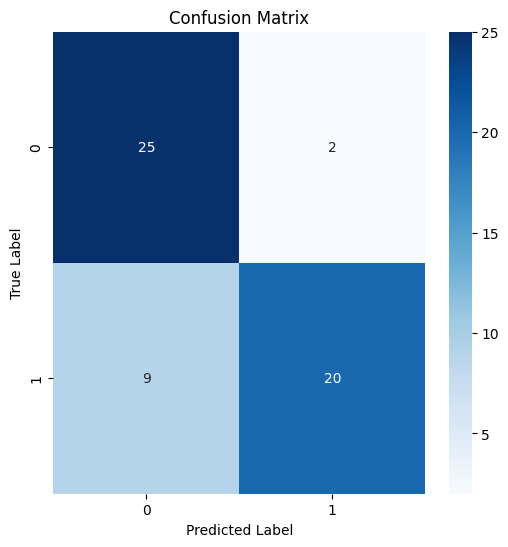

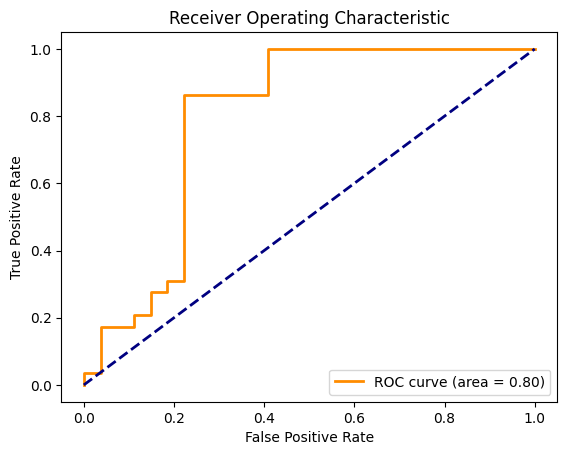

Average Precision Score: 0.7876735333631886


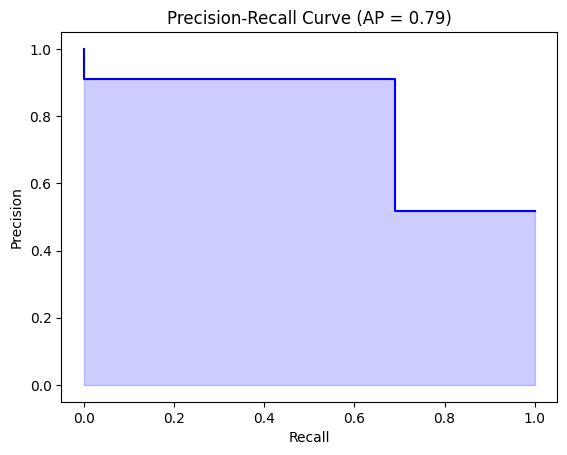

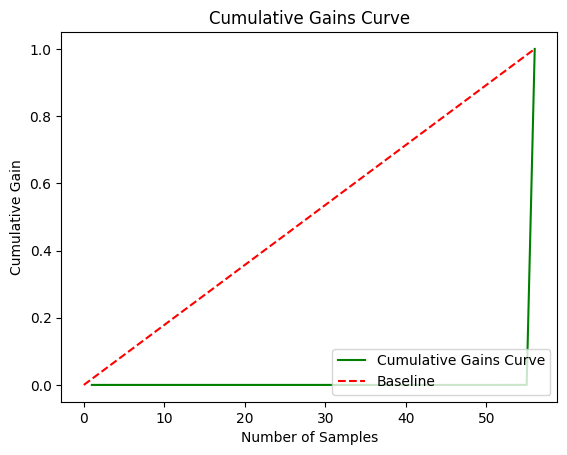

Number of Misclassified Samples: 11


<ipython-input-10-b5ee910007f2>:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Correct', 'Misclassified'], y=[len(y_test) - len(misclassified_indices), len(misclassified_indices)], palette='viridis')


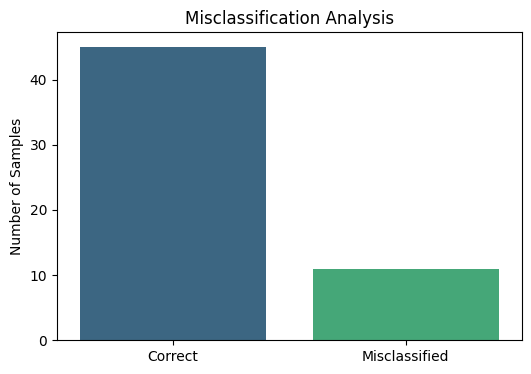

In [12]:
def main():
    filepath = r"/content/sample_data/cleaned_dataset.csv"
    data = load_data(filepath)

    X, y = preprocess_data(data)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = train_model(X_train, y_train)
    evaluate_model(model, X_test, y_test)

if __name__ == "__main__":
    main()